# 9. 임베딩 내 편향성 알아보기 [프로젝트]

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

---

**konlpy 관련 내용 정리**  
[Link](https://konlpy.org/ko/latest/api/konlpy.tag/#konlpy.tag._okt.Okt)  
[stem's dictionarical meaning: 2 of 6 verb(1)](https://www.merriam-webster.com/dictionary/stem)

---

`pos(phrase, norm=False, stem=False, join=False)`
- POS (Part Of Speech; a.k.a 품사)
    - **norm** : `True` 값이면, 단어(토큰)들을 정규화함
    - **stem** : ` True` 값이면, 단어(토큰)의 어근을 반환함
    - **join** : `True` 값이면, 단어를 품사로 변환해서 tag와 함께 반환함
        - [example applied join option](https://konlpy.org/en/v0.4.4/morph/)
    


In [1]:
# 형태소 분석기를 이용해 특정 품사인 단어를 추출하는 함수 선언
def extract_tokens(file_path, part_of_speech):
    # konlpy 모듈 임포트
    from konlpy.tag import Okt
    # konlpy 인스턴스 생성
    okt = Okt()
    tokenized = []
    with open(file_path, 'r') as file:
        while True:
            # text file 한 줄씩 읽기
            line = file.readline()
            # 파일 다 읽으면(line == None), break
            if not line: break
            ## 위 konlpy 관련 내용 정리 참고
            words = okt.pos(line, stem=True, norm=True)
            res = []
            for w in words:
                if w[1] in [part_of_speech]:      # "Noun, "Adjective", "Verb" 등을 포함 가능
                    res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
            tokenized.append(res)
    return tokenized
# 약 15분정도 걸립니다.

In [2]:
# 파일 경로, 추출할 품사 설정하고 함수 실행
import os
import time

file_path = os.getenv('HOME')+'/aiffel/weat/synopsis.txt'
part_of_speech = "Noun"


start_time = time.time()
# extract_tokens() 는 list를 반환함
## 글로벌 변수 tokenized를 가지고 return 값 받아오기
tokenized = extract_tokens(file_path, part_of_speech)
end_time = time.time()

print(f"extract_tokens() 함수 실행 소요시간 : {end_time - start_time} sec.")
print(f"변환한 토큰 개수 : {len(tokenized)}")

extract_tokens() 함수 실행 소요시간 : 680.520834684372 sec.
변환한 토큰 개수 : 71156


## STEP 2. 추출된 결과로 embedding model 만들기

---

In [3]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

# 모델 저장 용도(like as pretrained model)
model.save("word2vec.model")

```python
# Gensim 3.X 에서는 아래와 같이 생성합니다. 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)
```

In [4]:
# 학습예제와 동일한 조건의 테스트 해보기
model.wv.most_similar(positive=['영화'])

[('작품', 0.8777695894241333),
 ('다큐멘터리', 0.8594439029693604),
 ('드라마', 0.8065423965454102),
 ('영화로', 0.8017072677612305),
 ('코미디', 0.7783318161964417),
 ('형식', 0.7778170108795166),
 ('소재', 0.7706201672554016),
 ('편의', 0.7606302499771118),
 ('주제', 0.7602591514587402),
 ('설정', 0.7548930048942566)]

---

pretrainded model(`word2Vec.model`) 테스트

In [5]:
# 기존 model 제거
del model

# model이 제거 되었는지 확인해보기
## 정상적으로 제거되었다면 'model' is not defined 가 출력될 것이다.
model

NameError: name 'model' is not defined

In [6]:
# 사전 학습된 모델 불러오기
model = Word2Vec.load("word2vec.model")

# 모델이 잘 불렸는지 확인
model

In [7]:
# 학습 예제 1 테스트
model.wv.most_similar(positive=['사랑'])

[('애정', 0.7247534394264221),
 ('진심', 0.7008025050163269),
 ('연애', 0.6902377605438232),
 ('행복', 0.6831134557723999),
 ('가슴', 0.6816573143005371),
 ('만남', 0.6802330017089844),
 ('첫사랑', 0.6669242978096008),
 ('고백', 0.6660880446434021),
 ('욕망', 0.6652083396911621),
 ('이별', 0.6590585708618164)]

In [8]:
# 학습 예제 2 테스트
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.8939788937568665),
 ('시나리오', 0.8861426115036011),
 ('배우', 0.8741973638534546),
 ('데뷔', 0.8739330172538757),
 ('캐스팅', 0.8636925220489502),
 ('뮤지션', 0.8546149134635925),
 ('영감', 0.8532626628875732),
 ('팬', 0.8524744510650635),
 ('무용', 0.8497347235679626),
 ('여배우', 0.8488672971725464)]

## STEP 3. target, attribute 단어 셋 만들기

---

이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.  
  
TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

---

WEAT score를 구할 때, 단어 셋을 만들어야 한다.
- targets_X, targets_Y, attribute_A, attribute_B

예제 기준 &rarr; `영화 장르`, `영화 구분 정보`를 두 축으로 하였음  
  
- 영화 구분
    - `synopsis_art.txt` : `예술영화`
    - `synopsis_gen.txt` : `일반영화(상업영화)`
    - `synopsis_etc.txt` : `독립영화`
- 장르 구분
    - `synopsis_SF.txt` : `SF`
    - `synopsis_action.txt` : `액션`
    - `synopsis_adult.txt` : `성인물(에로)`
    - `synopsis_adventure.txt` : `어드벤처`
    - `synopsis_animation.txt` : `애니메이션`
    - `synopsis_comedy.txt` : `코미디`
    - `synopsis_crime.txt` : `범죄`
    - `synopsis_documentary.txt` : `다큐멘터리`
    - `synopsis_drama.txt` : `드라마`
    - `synopsis_family.txt` : `가족`
    - `synopsis_fantasy.txt` : `판타지`
    - `synopsis_historical.txt` : `사극`
    - `synopsis_horror.txt` : `공포(호러)`
    - `synopsis_musical.txt` : `뮤지컬`
    - `synopsis_mystery.txt` : `미스터리`
    - `synopsis_romance.txt` : `멜로로맨스`
    - `synopsis_show.txt` : `공연`
    - `synopsis_thriller.txt` : `스릴러`
    - `synopsis.txt` : `기타`
    - `synopsis_war.txt` : `전쟁`
    - `synopsis_western.txt` : `서부극(웨스턴)`
    
> 확인 명령어
```shell
$ cd /aiffel/aiffel/weat
$ ls | grep [^A-Z].txt | grep -v _art.txt | grep -v _gen.txt | grep -v _etc.txt
```
    

---

1. 일반영화(상업영화), 독립영화 : target으로 삼자
2. 다큐멘터리, SF : (장르) attribute로 삼자

- 가정
    - '다큐멘터리' 장르는 독립영화적 성격이 강할 것이다.
    - 'SF' 장르는 일반영화(상업영화)적 성격이 강할 것이다.
    
- what to do?
    - `synopsis_etc.txt`, `synopsis_gen.txt` : 타겟
    - `synopsis_documentary.txt`, `synopsis_SF.txt` : 장르 (attribute)

---

단어를 벡터화할 때, `TF-IDF` 변환의 한계점은 다음과 같다고 한다.
- 문서에 포함된 단어들만이 문서의 특징(feature)으로 영향을 미친다.
    - [참고논문 - 2. 관련연구](https://koreascience.kr/article/JAKO201824236535969.pdf)

저자는 문서 내의 단어의 의미와 순서를 문서 벡터에 표현하기 위해 `word2Vec` 과 `doc2vec`을 사용하여 벡터화를 수행하였다.
- 본 논문에서는 명사를 문서의 주요 특징으로 보고 형태소 분석을 통해 명사만을 추출한다. 추출된 명사 중에서도 다수의 문서에서 출현하는 단어는 문서간의 분별력을 낮추기 때문에 제거한다. 추출된 단어의 의미와 문맥을 고려하기 위해 word2vec을 사용하여 단어 벡터를 생성하고 doc2vec을 사용하여 문서를 벡터화한다

In [3]:
import os
from konlpy.tag import Okt

# 시놉시스 파일을 읽어서 토큰화하는 함수 선언
## 문장을 토크나이징 할 때, 명사만 추출해서 가져오기
def extract_nouns_from_file(file_name):
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r', encoding='utf-8') as file:
        text = file.read()
        okt = Okt()
        nouns = okt.nouns(text)
        return nouns

In [5]:
import time

# target 단어 셋 만들기
## `synopsis_etc.txt`, `synopsis_gen.txt` : 타겟
etc_txt = 'synopsis_etc.txt'
gen_txt = 'synopsis_gen.txt'
# attribute 단어 셋 만들기
## `synopsis_documentary.txt`, `synopsis_SF.txt` : attribute (장르)
documentary_txt = 'synopsis_documentary.txt'
science_fiction_txt = 'synopsis_SF.txt'

start_time = time.time()
# 각 텍스트 파일에서 명사 추출
etc_nouns = extract_nouns_from_file(etc_txt)
gen_nouns = extract_nouns_from_file(gen_txt)
documentary_nouns = extract_nouns_from_file(documentary_txt)
science_fiction_nouns = extract_nouns_from_file(science_fiction_txt)
#
end_time = time.time()

print(f"소요시간; {end_time - start_time} sec")

소요시간; 515.9143838882446 sec


In [50]:
from gensim.models import Word2Vec
# target (X, Y), attribute (A, B)
X, Y = list(), list()
A, B = list(), list()

# Word2Vec 부분이 반복적이므로 함수 선언
def w2v_model(nouns, target_word, target_or_attribute_list):
    # 모델 학습 - 명사 단어 기반
    model = Word2Vec([nouns], vector_size=100, window=5, min_count=1, sg=0, workers=4)

    # 대표 단어 - 단어 뭉치 기준 관련성이 높은 10개 단어 추출
    similar_words = model.wv.most_similar(positive=target_word, topn=10)
    
    # 대표 단어와 유사한 단어 10개 출력
    ## 하면서 target_1 (X) 에 append
    print(f"{target_word}과 관련 있는 상위 10개 단어들:")
    for word, similarity in similar_words:
        # target or attribute
        target_or_attribute_list.append(similarity)
        print(f"{word}: {similarity:.4f}")

    # 학습했던 모델 제거
    del model

In [51]:
# 독립영화 - target X로
w2v_model(etc_nouns, "독립영화", X)

독립영화과 관련 있는 상위 10개 단어들:
작전: 0.4242
얼: 0.3949
미코: 0.3320
보건: 0.3175
쉬: 0.3171
강조: 0.3162
졸업: 0.3114
도살: 0.3091
프랑: 0.2996
헤더: 0.2933


In [52]:
# 일반영화 - target Y로
w2v_model(gen_nouns, "일반", Y)

일반과 관련 있는 상위 10개 단어들:
호놀: 0.4034
로퍼: 0.3798
카를로: 0.3764
왼쪽: 0.3751
살박: 0.3717
나비문신: 0.3678
티나: 0.3650
사슬: 0.3552
우체국: 0.3536
세혁: 0.3487


In [53]:
# 일반영화 - attribute A로
w2v_model(documentary_nouns, "다큐", A)

다큐과 관련 있는 상위 10개 단어들:
수련: 0.3405
슈사: 0.3375
파바로티: 0.3289
현대: 0.3258
위험: 0.3187
직물: 0.3142
늪: 0.3125
만능: 0.3123
생태계: 0.3120
임흥세: 0.3102


In [54]:
# 일반영화 - attribute B로
w2v_model(science_fiction_nouns, "과학", B)

과학과 관련 있는 상위 10개 단어들:
중위: 0.3369
북: 0.3263
홍보: 0.3186
여섯: 0.3180
철통: 0.3166
처치: 0.3041
증폭: 0.3026
송강호: 0.2979
지벤스: 0.2925
타이탄: 0.2916


## STEP 4. WEAT score 계산과 시각화

---

영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

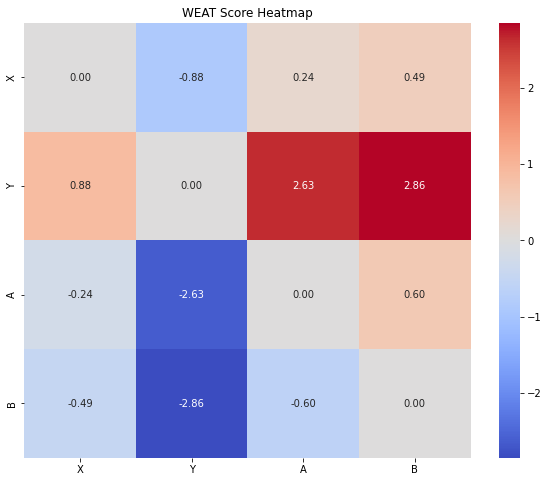

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


# 각각의 단어 목록을 리스트로 묶기
word_lists = [X, Y, A, B]
word_labels = ['X', 'Y', 'A', 'B']

# WEAT 스코어 계산
def calculate_weat_score(target_list, attribute_list):
    target_mean = np.mean(target_list)
    attribute_mean = np.mean(attribute_list)
    
    target_std = np.std(target_list)
    attribute_std = np.std(attribute_list)
    
    weat_score = (target_mean - attribute_mean) / np.sqrt(target_std ** 2 + attribute_std ** 2)
    return weat_score

# WEAT 스코어 행렬 생성
num_words = len(X)
weat_scores = np.zeros((len(word_labels), len(word_labels)))

for i, target_list in enumerate(word_lists):
    for j, attribute_list in enumerate(word_lists):
        weat_scores[i, j] = calculate_weat_score(target_list, attribute_list)

# HEATMAP 그리기
df = pd.DataFrame(weat_scores, index=word_labels, columns=word_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("WEAT Score Heatmap")
plt.show()

### 루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.

|**평가문항**|**상세기준**|
|---|---|
|1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.|
|2. 영화 구분, 장르별로 target, attribute에 대표성있는 단어셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|
|3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|

# 개인 회고

---

1. konlpy 형태소 분석기 사용을 통해 특정 품사를 가지는 단어 추출하는 법을 잘 배운거 같다.
2. word2vec을 사용해서 WEAT score를 구해보려고 했는데, 뭔가 지저분하게 구해진것 같다
	- 확신의 포인트가 없달까(...)
3. 데이터 시각화로 하는 분석에 대해 심도있게 접근해보아야 할 것 같다..